In [1]:
pip install tabgan==1.3.3

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install lightgbm

In [3]:
pip install --upgrade pandas "dask[complete]"

Note: you may need to restart the kernel to use updated packages.


In [4]:
## librerias requeridas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
#from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
#from scikitplot.metrics import plot_lift_curve
#from scikitplot.helpers import binary_ks_curve 
#from scikitplot.metrics import plot_ks_statistic
#from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [5]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

## Cargo el modelo y los datos a los que lo voy a aplicar 

In [6]:
import os
os.getcwd()

'/home/ec2-user/SageMaker/viamericas-dev/Analytics/5.Fraud'

In [7]:
import os
import joblib
# load model
#modelo = joblib.load("Analytics/5.Fraud/ModeloV1Todos.pkl") 
modelo = joblib.load("ModeloFinalLimpio.pkl") 
variables = open('./ModeloFinalLimpio.txt','r')
##ModeloV1T1

In [8]:
modelo

LGBMClassifier(colsample_bytree=0.84, force_col_wise='True',
               importance_type='gini', learning_rate=0.07, max_depth=20,
               min_child_weight=0.0026, n_estimators=520, num_leaves=30,
               objective='binary', scale_pos_weight=0.003, subsample=1)

# Veo si puedo sacar los nombres directo del modelo q cargue


In [9]:
#variables = open('./ModeloFinal2.txt','r')
#var_input = variables.read()

In [10]:
var_input = ['branch_minutes_since_last_transaction',
    'branch_trans_3m',  'branch_has_fraud',  
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','01_isMexico', 
    '01_sender_branch_state', '01_var_range_hist', 
    '01_branch_fraud', '01_location_fraud', '01_sender_fraud', 
    '01_isCashPick', '01_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    '01_receiver_transaction_count','01_sender_sending_days',
    '01_branch_working_days', '01_net_amount_receiver', 
    '01_sender_minutes_since_last_transaction_2days', 
    '01_sender_days_to_last_transaction_365', 
    '01_sender_days_to_last_transaction_7m', '01_hour_receiver']

In [11]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
dfTrain = pd.read_parquet(f"s3://{s3_url}/Train/Train.parquet")
tgTrain = dfTrain['target']

dfVal = pd.read_parquet(f"s3://{s3_url}/Validation/Validation.parquet")
tgVal = dfVal['target']

#Uni test y Val
#X = pd.concat([dfTrain[var_input], dfVal[var_input]], ignore_index=True) 
X = pd.concat([dfTrain, dfVal], ignore_index=True) 
Y = pd.DataFrame(pd.concat([dfTrain['target'], dfVal['target']], ignore_index=True)) 

dias_target = ['day_name_receiver_0', 'day_name_receiver_1',
       'day_name_receiver_2', 'day_name_receiver_3',
       'day_name_receiver_4', 'day_name_receiver_5',
       'day_name_receiver_6','target']

testeo =  pd.concat([X, Y], axis=1)
Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target]], ignore_index=True)) 

In [62]:
testeo[var_input]

,branch_minutes_since_last_transaction,branch_trans_3m,branch_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,sender_nro_fraud,01_isMexico,01_sender_branch_state,01_var_range_hist,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_more7m,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
0,2.00000000000000000000,7568,0,9,3,8,0,5,0,False,True,0.57352500748727164304,False,False,False,True,False,0,0.15789473684210525439,1.00000000000000000000,0.39147286821705423732,0.14002529961026902172,0.00000000000000000000,0.08493150684931506655,0.14761904761904762196,0.83333333333333337034
1,3.00000000000000000000,607,0,2,2,2,0,20,0,False,True,0.92855001112325508128,False,False,False,True,False,0,0.11578947368421052544,1.00000000000000000000,0.17475564543309740628,0.03509772522868361694,0.00000000000000000000,0.01643835616438356004,0.02857142857142857054,0.54166666666666662966
2,1.00000000000000000000,2644,0,4,1,2,0,13,0,True,True,1.25137234701257638037,False,False,False,False,True,0,0.26315789473684209065,0.54189944134078216198,0.03353555780249409951,0.06763624132610905615,0.00034722222222222224,0.00000000000000000000,0.00000000000000000000,0.75000000000000000000
3,10.00000000000000000000,1807,0,4,1,2,0,1,0,False,True,1.00000000000000000000,False,False,False,False,False,0,0.00000000000000000000,NaN,0.01904280417930569527,0.51184182625163610059,NaN,NaN,NaN,0.70833333333333337034
4,82.00000000000000000000,301,0,1,1,0,0,9,0,True,True,1.22282608695652172948,False,False,False,False,True,0,0.33684210526315788714,1.00000000000000000000,0.02746882372767104827,0.09140032611636358939,0.00000000000000000000,0.03835616438356164587,0.06666666666666666574,0.79166666666666662966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488370,3.00000000000000000000,988,0,8,3,4,0,10,0,False,False,1.33075648812810598542,False,False,False,True,False,0,0.92631578947368420351,1.00000000000000000000,0.15385911695315132586,0.08810991437617450572,0.00000000000000000000,0.01917808219178082293,0.03333333333333333287,0.83333333333333337034
6488371,9.00000000000000000000,6717,0,4,2,2,0,6,0,False,True,1.37180700094607388451,False,False,False,True,False,0,0.18947368421052632192,1.00000000000000000000,0.45601617795753285334,0.53012189147490884622,0.00000000000000000000,0.03835616438356164587,0.06666666666666666574,0.45833333333333331483
6488372,70.00000000000000000000,692,0,1,1,1,0,5,0,True,True,0.68493150684931503047,False,False,False,True,False,0,0.03157894736842105365,1.00000000000000000000,0.31142568250758340120,0.07312026089309087151,0.00000000000000000000,0.07671232876712329174,0.13333333333333333148,0.45833333333333331483
6488373,"1,057.00000000000000000000",233,0,1,1,1,0,2,0,True,True,1.80000000000000004441,False,False,False,True,False,0,0.00000000000000000000,1.00000000000000000000,0.33080552746882374571,0.65808234803781784361,0.00000000000000000000,0.07671232876712329174,0.13333333333333333148,0.45833333333333331483


In [13]:
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Creando una copia del DataFrame 'Y_c' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

#Calculo el primer percentil para sacar el punto de corte
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')


In [14]:
#saco el punto de corte del primer centil para aplicarlo al test
corte2 = Y_c.score_rf[Y_c['FRAUD_DECILE']==2].min()
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==1].min()

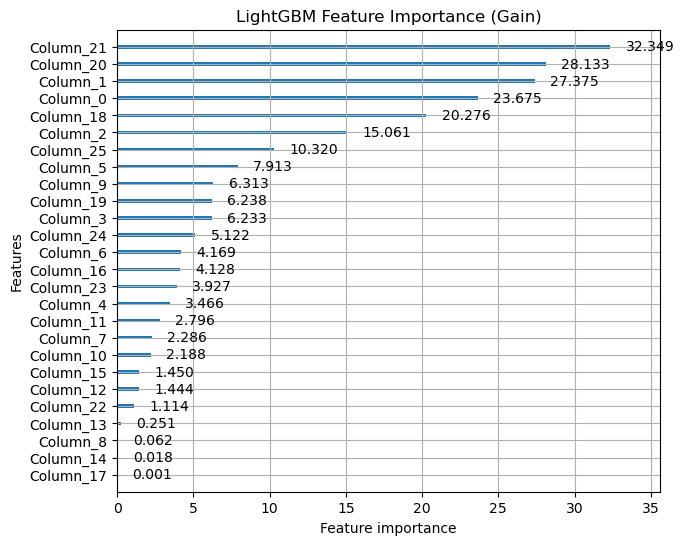

In [15]:
import lightgbm as lgb
lgb.plot_importance(modelo, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

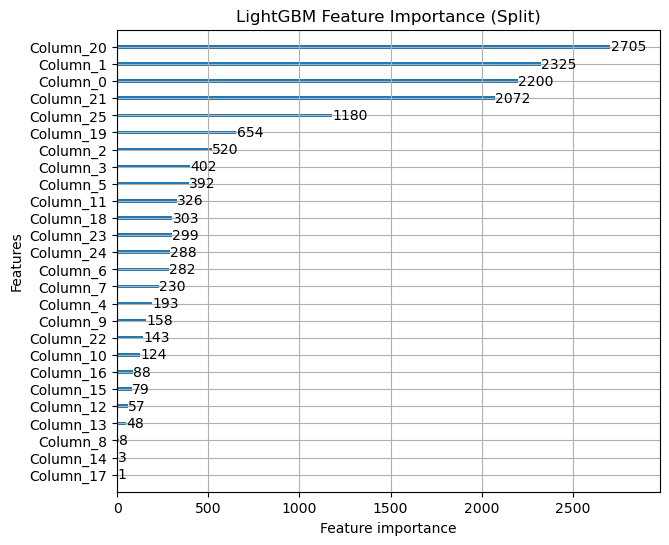

In [16]:
# Plot feature importance using Split
lgb.plot_importance(modelo, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

In [17]:
#Pongo el archivo q quiero testear
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Data2024/Data2024.parquet")
#s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model"
#tes = pd.read_parquet(f"s3://{s3_url}/TargetTodos/Test/Test.parquet")

##lista de variables de input
X = tes[var_input]
Y = tes[['target']]

#testeo = pd.concat([testeo, tes], axis = 0, ignore_index=True)
#Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target], tes[dias_target]], ignore_index=True)) 
testeo =  tes.copy()
Y_target = pd.DataFrame(tes[dias_target]) 

In [18]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe

testeo = limpiar_nombres_columnas(testeo)

In [19]:
testeo['target'].value_counts(dropna=False)

target
False    6488319
True          56
Name: count, dtype: int64

In [20]:
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [21]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

In [22]:
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,6488319,0
1,53,3


In [23]:
corte

4.21335052945521e-07

In [63]:
Y_c['pred_corte'] = Y_c['score_rf']>corte2
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,6482227,6092
1,40,16


In [25]:
#import seaborn as sns
#sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [26]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA .04%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))
#Y_TESTEO_c.to_csv(r'./SCORES/primera_prueba.csv')

FRAUD CAPTURA .04%:
0.5178571428571429


In [64]:
DECILES = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])
DECILES

target,False,True
FRAUD_DECILE,,
1,6473,16
2,6482,6
3,6482,7
4,6485,3
5,6488,0
...,...,...
996,6488,0
997,6488,0
998,6489,0


In [65]:
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}) 

score_rf                       
                                min                    max
FRAUD_DECILE                                              
1            0.00000011600516281127 0.87290681569757966329
2            0.00000004441274252661 0.00000011598213495224
3            0.00000002503883385794 0.00000004440908033155
4            0.00000001666218207555 0.00000002503509180122
5            0.00000001225422229332 0.00000001666190799540
...                             ...                    ...
996          0.00000000000008068522 0.00000000000009239878
997          0.00000000000006795478 0.00000000000008068322
998          0.00000000000005307422 0.00000000000006795235
999          0.00000000000003423309 0.00000000000005306836
1000         0.00000000000000066370 0.00000000000003422933

[1000 rows x 2 columns]

In [66]:
tes_corte = testeo[Y_c['pred_corte']==True]
Y_c_corte = Y_c[Y_c['pred_corte']==True]
pd.crosstab(tes_corte['date_receiver'].dt.month, Y_c_corte['target'])
#pd.crosstab(testeo['date_receiver'].dt.month, Y_c['target'])

target,False,True
date_receiver,,
1,1941,12
2,2054,3
3,2097,1


In [30]:
tes_corte.to_csv ('./Corte.csv')

In [31]:
deciles_semana = Y_c[['day_name_receiver_0', 'day_name_receiver_1',
                   'day_name_receiver_2', 'day_name_receiver_3',
                   'day_name_receiver_4', 'day_name_receiver_5',
                   'day_name_receiver_6',
                 'FRAUD_DECILE']].groupby(['FRAUD_DECILE']).sum()

deciles_semana.head(10)

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6
FRAUD_DECILE,,,,,,,
1,900,855,725,780,1068,1234,927
2,892,797,732,779,1012,1269,1007
3,840,805,733,700,1063,1364,984
4,878,751,723,746,1042,1347,1001
5,918,814,688,750,1040,1287,991
6,920,814,688,730,1082,1258,997
7,864,778,687,754,1079,1314,1012
8,875,793,675,756,1070,1282,1037
9,899,768,716,719,1090,1264,1033


In [32]:
#DECILES.to_csv ('./deciles.csv')

# Buckets para codificar Score

In [67]:
 Y_c['FRAUD_DECILE'].value_counts()

FRAUD_DECILE
236    6489
845    6489
431    6489
722    6489
738    6489
       ... 
544    6488
370    6488
842    6488
291    6488
39     6488
Name: count, Length: 1000, dtype: Int64

In [34]:
#Guardo los puntos de corte para recodificar el score
pd.options.display.float_format = "{:,.20f}".format
Buckets = Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}).stack(0, future_stack=True)
Buckets = Buckets.reset_index()
Buckets['final_score'] = 1-(Buckets['FRAUD_DECILE']/1000)
Buckets[['FRAUD_DECILE','min','max','final_score']].to_csv ('./Buckets.csv')

Y_c['score_rf2'] = 0
Y_c['score_rf2'] = Y_c['score_rf2'].astype(str) 
for i in range(Y_c.shape[0]):
    a = Buckets.loc[(Y_c.loc[i,'score_rf'] <= Buckets['max']) & (Y_c.loc[i,'score_rf'] >= Buckets['min']), 'final_score'] 
    Y_c.loc[i,'score_rf2'] = a.item()

In [35]:
#Y_c.loc[1,['score_rf2','FRAUD_DECILE']] 

In [36]:
Buckets[Buckets['FRAUD_DECILE']==644]

,FRAUD_DECILE,level_1,min,max,final_score
643,644,score_rf,0.00000000000395778952,0.00000000000397726613,0.35599999999999998312


## Curva ROC y FP

In [37]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [38]:
%pip install scipy==1.11.4

Note: you may need to restart the kernel to use updated packages.


In [39]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve

In [40]:
# Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
classes = np.unique(Y_c[['target']])
percentages, gains = cumulative_gain_curve(Y_c[['target']], Y_c['score_rf'], classes[1])
percentages = percentages[1:]
gains = gains[1:]
gains = gains / percentages
indice = round(len(gains) * 0.1)
print('LIFT FRAUD TESTEO:')
print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
print('ROC FRAUD TESTEO:')
print(roc_auc_score(Y_c[['target']], Y_c['preds_rf']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_c[['target']], Y_c['score_rf'])
print('KS FRAUD TESTEO:')
print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
precision = precision_score(Y_c[['target']], Y_c['preds_rf'])
recall = recall_score(Y_c[['target']], Y_c['preds_rf'])
print('Precision FRAUD TESTEO:')
print(precision)
print('Recall FRAUD TESTEO:')
print(recall)

LIFT FRAUD TESTEO:
8.214266724322762
ROC FRAUD TESTEO:
0.5267857142857143


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KS FRAUD TESTEO:
0.7610187053071835
Precision FRAUD TESTEO:
1.0
Recall FRAUD TESTEO:
0.05357142857142857


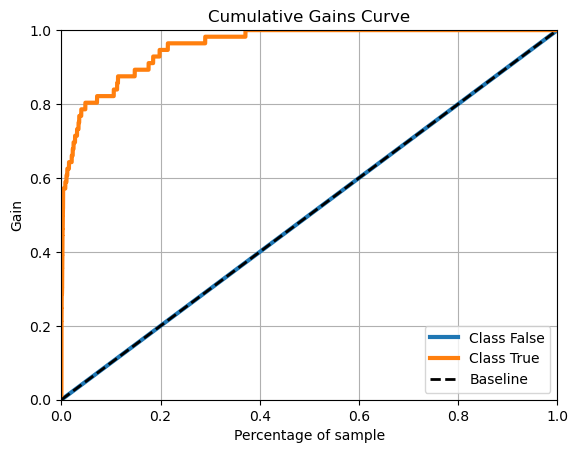

In [41]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_true=Y_c[['target']], y_probas =  probab_rf)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


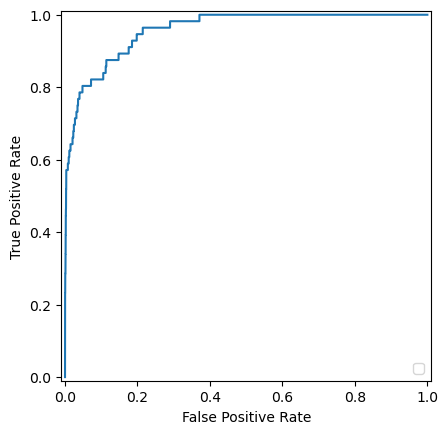

In [42]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(Y_c[['target']], score_rf)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

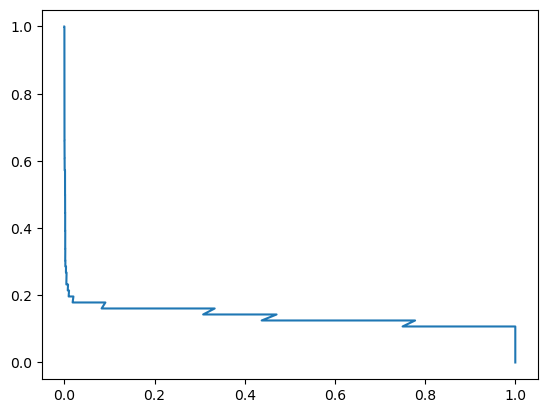

In [43]:
precision, recall, thresholds = skplt.metrics.precision_recall_curve(Y_c[['target']], score_rf)
plt.plot(precision, recall)

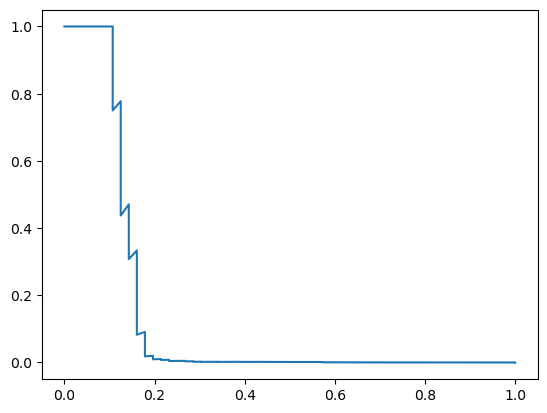

In [44]:
plt.plot(recall, precision)

## One given week

In [45]:
tes[tes['target']==True].head()

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,receiver_transaction_count,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_G,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target
247429,A25678,455,2024-01-30 15:02:56.657,IN0165,NN,11179431,"2,500.00000000000000000000",MEX,MEX33,IN,78,37.00000000000000000000,2.00000000000000000000,USA,Real,"2,817.00000000000000000000",69.00000000000000000000,0,426,IN,0,0,1,1,0,0,6,"1,120.33333333333325754211",0,1.00000000000000000000,1,15,True,True,2.23147872656947354741,False,False,False,False,False,True,2.00000000000000000000,0,2.00000000000000000000,0,"2,817.00000000000000000000",0.00000000000000000000,0.00000000000000000000,0.05167597765363128592,0.01550387596899224785,0.91400326116363594942,0.97812500000000002220,0.00000000000000000000,0.00547945205479452059,0.00952380952380952467,0.62500000000000000000,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True
553274,A25718,46,2024-01-24 18:16:31.533,NY1546,NN,10303412,"1,500.00000000000000000000",MEX,MEX33,NY,65,210.00000000000000000000,34.00000000000000000000,USA,Real,"49,208.00000000000000000000",9.00000000000000000000,0,39,CA,1,1,2,2,0,1,2,"1,700.00000000000000000000",1,1.00000000000000000000,1,18,True,False,0.88235294117647056211,True,True,True,True,False,True,34.00000000000000000000,0,34.00000000000000000000,0,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.29329608938547485630,0.01331311088641725683,0.54840195669818159185,0.00000000000000000000,0.00000000000000000000,0.09315068493150685525,0.16190476190476191243,0.75000000000000000000,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True
650090,A25718,47,2024-01-24 18:24:18.070,NY1546,NN,11306118,"1,500.00000000000000000000",MEX,MEX25,NY,65,NaN,NaN,USA,Real,NaN,8.00000000000000000000,0,40,CA,2,0,3,2,0,2,1,"1,500.00000000000000000000",0,1.00000000000000000000,1,18,True,False,1.00000000000000000000,False,True,True,False,False,True,NaN,0,NaN,0,NaN,NaN,0.00000000000000000000,NaN,0.01331311088641725683,0.54840195669818159185,NaN,NaN,NaN,NaN,0.75000000000000000000,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True
831829,A22792,11766,2024-01-19 17:47:25.867,NV0185,NN,11283276,980.00000000000000000000,MEX,MEX27,NV,583,NaN,NaN,USA,Real,NaN,30.00000000000000000000,0,2475,NV,3,0,1,1,0,3,1,980.00000000000000000000,0,1.00000000000000000000,1,17,True,True,1.00000000000000000000,False,True,True,False,False,True,NaN,

In [46]:
week_testigo = tes['date_receiver'].between('2024-01-01','2024-01-30')
X_week_testigo = tes[week_testigo]
Y_c_week_testigo = Y_c[week_testigo]

week_testigo.sum(), X_week_testigo.shape, Y_c_week_testigo.shape

(1914258, (1914258, 77), (1914258, 12))

In [47]:
pd.crosstab(X_week_testigo['date_receiver'].dt.day, Y_c_week_testigo['target'])

target,False,True
date_receiver,,
1,14355,0
2,62656,0
3,51698,0
4,52180,0
5,79981,1
6,86777,0
7,73472,5
8,62604,0
9,47749,0


In [48]:
#Veo cuantos falsos positivos tengo con el punto de corte
X_week_testigo_corte = X_week_testigo[Y_c_week_testigo['pred_corte']==True]
Y_c_week_testigo_corte = Y_c_week_testigo[Y_c_week_testigo['pred_corte']==True]

pd.crosstab(X_week_testigo_corte['date_receiver'].dt.day, Y_c_week_testigo_corte['target'])

target,False,True
date_receiver,,
1,7,0
2,28,0
3,14,0
4,16,0
5,24,0
6,23,0
7,12,4
8,35,0
9,22,0


In [49]:
Tabla_Week = pd.DataFrame(pd.concat([X_week_testigo['date_receiver'].dt.day,X_week_testigo['fraud_classification'], 
                                     Y_c_week_testigo['FRAUD_DECILE'], Y_c_week_testigo['target']],axis=1))

In [50]:
Tabla_Week[Tabla_Week['target']==True]
pd.crosstab(Tabla_Week.date_receiver, Tabla_Week.FRAUD_DECILE)

FRAUD_DECILE,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,...,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000
date_receiver,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,16,18,15,10,12,18,13,17,10,16,12,18,10,17,6,20,11,18,11,11,21,16,9,16,9,13,20,15,14,15,10,7,11,13,14,15,11,10,14,18,13,13,12,22,7,9,22,12,14,14,15,20,22,11,11,17,20,15,16,16,12,10,13,14,14,10,22,16,15,20,23,18,11,16,13,20,13,13,20,14,10,14,14,11,11,14,14,16,15,13,14,11,20,23,14,21,20,17,17,12,11,18,10,21,20,9,14,14,15,16,13,14,16,9,16,21,14,19,10,13,18,16,13,19,17,15,14,13,18,5,14,15,19,13,12,17,11,15,18,16,11,13,17,12,14,15,15,12,22,24,14,16,14,17,16,15,18,14,20,22,19,10,15,10,19,10,14,16,18,17,21,9,18,13,14,17,16,17,12,12,19,18,20,20,14,17,8,18,17,10,10,13,12,8,11,14,17,18,16,12,16,13,18,20,14,18,18,20,12,15,16,21,19,18,12,11,10,21,9,15,11,16,16,12,16,21,14,16,10,10,16,17,11,16,13,16,9,13,13,11,5,18,16,21,18,21,9,14,21,12,...,24,19,11,15,14,14,14,10,9,16,15,8,9,15,9,15,11,14,17,9,14,15,10,23,15,11,11,15,14,9,12,15,14,13,16,16,14,14,10,15,13,15,15,14,12,15,12,19,15,10,16,12,13,11,15,10,19,8,9,13,9,19,19,11,12,14,7,21,11,14,8,13,10,15,11,12,11,11,14,15,9,11,16,12,11,17,9,8,6,10,11,9,6,11,14,12,14,12,6,10,12,9,11,12,11,12,11,17,8,16,7,20,9,14,8,16,9,17,14,10,8,11,17,13,8,7,15,15,16,10,10,11,15,7,22,15,14,8,18,11,12,11,14,15,9,11,8,15,9,15,13,22,13,21,8,12,15,15,18,13,11,13,14,14,12,12,20,9,15,15,10,14,11,11,7,11,18,11,15,13,17,16,19,15,11,7,18,15,6,13,16,15,16,10,14,14,16,21,8,13,7,15,17,9,10,11,16,10,17,12,13,10,10,13,13,15,9,14,16,19,11,17,17,16,8,7,16,20,16,13,18,14,16,18,14,11,13,20,11,13,23,19,19,13,18,21,21,22,24,21
2,62,59,60,59,66,56,60,58,51,69,40,62,68,64,61,46,63,62,61,51,56,53,60,58,40,53,59,52,74,50,54,68,60,65,58,46,63,66,47,70,57,63,

In [51]:

pd.crosstab(Tabla_Week.date_receiver[Tabla_Week['target']==True], Tabla_Week.FRAUD_DECILE[Tabla_Week['target']==True])

FRAUD_DECILE,1,2,3,4,28,49,113
date_receiver,,,,,,,
5,0,0,0,0,0,0,1
7,4,0,0,0,0,1,0
14,2,0,0,0,1,0,0
19,0,3,1,1,0,0,0
21,3,0,1,0,0,0,0
24,3,0,0,0,0,0,0


In [52]:
Tabla_Week.loc[Tabla_Week['target']==True,['date_receiver','fraud_classification','FRAUD_DECILE']]

,date_receiver,fraud_classification,FRAUD_DECILE
553274,24,Real,1
650090,24,Real,1
831829,19,Real,4
835507,21,Real,1
861348,14,Real,28
861731,5,Real,113
902767,21,Real,3
958633,7,Real,1
1030155,7,Real,1
1054171,21,Real,1


# Analisis extra por cantidad FP

In [53]:
testeo.loc[(testeo['id_receiver'] ==30890) & (testeo['id_branch'] =='A14536')] 
#testeo['id_branch'] =='A14536'

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,receiver_transaction_count,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_G,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target
4574031,A14536,30890,2024-03-20 12:42:15.783,MA0108,NN,5717054,"1,050.50000000000000000000",BRA,BRA2,MA,2751,888.00000000000000000000,35.00000000000000000000,USA,None,"50,478.00000000000000000000",24.00000000000000000000,0,1116,MA,0,0,2,1,0,0,4,"2,492.06999999999970896170",0,28.00000000000000000000,3,12,False,True,0.42153711573109908795,False,False,False,False,False,True,35.00000000000000000000,0,35.00000000000000000000,0,0.00000000000000000000,0.00000000000000000000,0.28421052631578946901,1.00000000000000000000,0.46595888102460397695,0.38406417034095979846,0.00000000000000000000,0.00000000000000000000,0.09589041095890410427,0.16666666666666665741,0.50000000000000000000,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='date_receiver', ylabel='Count'>

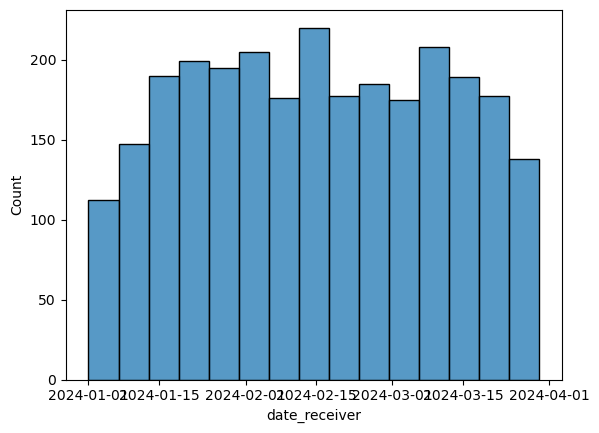

In [54]:
import seaborn as sns
sns.histplot(data = tes_corte['date_receiver'].dt.floor('d'))

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='date_receiver', ylabel='Count'>

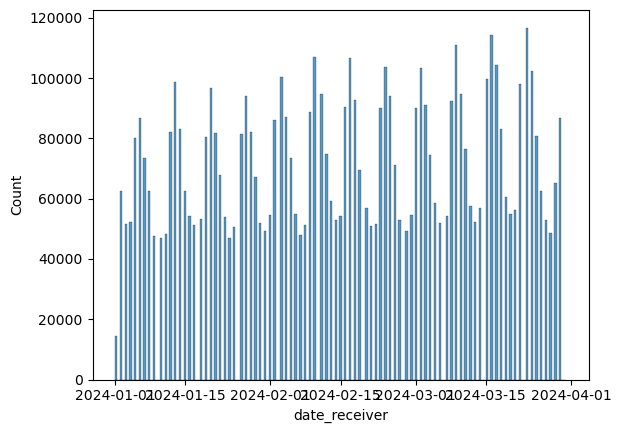

In [55]:
sns.histplot(data = testeo['date_receiver'].dt.floor('d'))

In [56]:

Alertas_2024 = pd.crosstab(tes_corte['date_receiver'].dt.floor('d'), Y_c_corte['target'])
Alertas_2024.to_csv ('./alertas2024.csv')

In [57]:
testeo[testeo['mes']==1].describe()

,id_receiver,date_receiver,id_sender_global,net_amount_receiver,branch_working_days,sender_sending_days,sender_days_to_last_transaction,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,receiver_transaction_count,mes,hour_receiver,01_var_range_hist,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
count,"2,015,553.00000000000000000000",2015553,"2,015,553.00000000000000000000","2,015,553.00000000000000000000","2,015,553.00000000000000000000","1,909,527.00000000000000000000","1,909,527.00000000000000000000","1,909,527.00000000000000000000","2,015,526.00000000000000000000","2,015,553.00000000000000000000","2,015,553.00000000000000000000","2,015,553.00000000000000000000","2,015,553.00000000000000000000","2,015,553.00000000000000000000","2,015,553.00000000000000000000","2,015,553.00000000000000000000","2,015,553.00000000000000000000","2,015,553.00000000000000000000","2,015,553.00000000000000000000","2,015,553.00000000000000000000","2,015,553.00000000000000000000","2,015,553.00000000000000000000","2,015,553.00000000000000000000","2,015,553.00000000000000000000","1,909,527.00000000000000000000","2,015,553.00000000000000000000","1,909,527.00000000000000000000","2,015,553.00000000000000000000","1,909,527.00000000000000000000","1,909,527.00000000000000000000","2,015,553.00000000000000000000","1,909,527.00000000000000000000","2,015,553.00000000000000000000","2,015,553.00000000000000000000","1,909,527.00000000000000000000","1,909,527.00000000000000000000","1,909,527.00000000000000000000","1,909,527.00000000000000000000","2,015,553.00000000000000000000"
mean,"68,008.93160884382086805999",2024-01-17 03:17:53.523458304,"8,253,911.59032235853374004364",459.43698657202259028054,"1,604.26221587822305991722",558.13400020004951329611,30.83989647698095026840,"44,413.68851867504417896271",111.13171102729511119378,0.00000000000000000000,"3,690.14762896336651465390",0.09084603580258122923,0.01329312600561731623,4.16461239173566788452,1.91828991844917995380,2.70342878604531877684,0.09108120699381261343,8.39294178818418501464,463.64038344820687598258,0.00008136724759904602,13.71094930274718670660,1.00000000000000000000,15.26109360557623695342,0.98372212652609702932,23.67514572980638831723,0.01145591309184129658,19.72511674357052768869,0.02506855438681096504,93.69131360802963115475,24.68525346852911894757,0.13049281212023125520,0.63509280953787827784,0.27211495584833955697,0.16496441868435821054,0.03253170611389917533,0.01714253713092299056,0.06486341295837363963,0.09392912735033587257,0.63587890023234283632
min,1.00000000000000000000,2024-01-01 03:00:23.573000,9.00000000000000000000,0.00000000000000000000,-19.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,3.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.0000000000000000000

In [58]:
testeo[testeo['mes']==3].describe()

,id_receiver,date_receiver,id_sender_global,net_amount_receiver,branch_working_days,sender_sending_days,sender_days_to_last_transaction,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,receiver_transaction_count,mes,hour_receiver,01_var_range_hist,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
count,"2,351,119.00000000000000000000",2351119,"2,351,119.00000000000000000000","2,351,119.00000000000000000000","2,351,119.00000000000000000000","2,240,171.00000000000000000000","2,240,171.00000000000000000000","2,240,171.00000000000000000000","2,345,986.00000000000000000000","2,351,119.00000000000000000000","2,351,119.00000000000000000000","2,351,119.00000000000000000000","2,351,119.00000000000000000000","2,351,119.00000000000000000000","2,351,119.00000000000000000000","2,351,119.00000000000000000000","2,351,119.00000000000000000000","2,351,119.00000000000000000000","2,351,119.00000000000000000000","2,351,119.00000000000000000000","2,351,119.00000000000000000000","2,351,119.00000000000000000000","2,351,119.00000000000000000000","2,351,119.00000000000000000000","2,240,171.00000000000000000000","2,351,119.00000000000000000000","2,240,171.00000000000000000000","2,351,119.00000000000000000000","2,240,171.00000000000000000000","2,240,171.00000000000000000000","2,351,119.00000000000000000000","2,240,171.00000000000000000000","2,351,119.00000000000000000000","2,351,119.00000000000000000000","2,240,171.00000000000000000000","2,240,171.00000000000000000000","2,240,171.00000000000000000000","2,240,171.00000000000000000000","2,351,119.00000000000000000000"
mean,"69,113.72116341197397559881",2024-03-15 21:12:18.347200512,"8,390,963.95521749369800090790",443.24371015116594207939,"1,608.30149898835406929720",584.70363467788843081507,31.66266816238581682796,"45,599.86644546331808669493",94.41788442045263707314,0.00000000000000000000,"3,537.01750996015107375570",0.09084610349369810767,0.01448033893648088474,4.49729341645403746242,2.02004322197217600632,2.93578164269864672065,0.09104600830498157937,8.05021736458256675917,440.68267558766069669218,0.00008251390082764845,14.32608217618929558057,3.00000000000000000000,15.48592180999770739902,1.00725070104817593375,23.96334476252036083110,0.01213805000937851278,19.95675196223859870770,0.02594849516336689144,99.08904722005597420775,26.49771780814946708915,0.13632991913973499520,0.64898491488113696501,0.27267365274296895272,0.15950887768967764169,0.03440591917363055446,0.01840119292232601442,0.06565299934937092463,0.09503215220113617190,0.64524674208323795632
min,1.00000000000000000000,2024-03-01 03:00:17.187000,9.00000000000000000000,0.73999999999999999112,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.91266666666666662611,0.00000000000000000000,0.00000000000000000000,3.00000000000000000000,3.00000000000000000000,0.00066489067717885424,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00235928547354229872,0

for var in var_input:
    sns.histplot(data = tes_corte, x=var, hue = 'mes')
    plt.show()

In [59]:
week_fraude = tes['date_receiver'].between('2024-03-21','2024-03-22')
X_fraude = tes[week_fraude]
Y_c_fraude = Y_c[week_fraude]
X_fraude[Y_c_fraude['pred_corte']==True].sort_values(by=['id_branch'])

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,receiver_transaction_count,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_G,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target
4259908,A05945,70912,2024-03-21 21:29:02.273,AL0152,NN,6915613,"1,878.00000000000000000000",MEX,MEX15,AL,4957,"1,152.00000000000000000000",10.00000000000000000000,USA,None,"15,071.00000000000000000000",28.00000000000000000000,0,2446,AL,9,0,5,1,0,9,17,656.37529411764671749552,0,1.00000000000000000000,3,21,True,True,2.86116801901351403004,False,True,True,False,False,True,10.00000000000000000000,0,10.00000000000000000000,0,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.83771486349848334196,0.68659924978612330015,0.00000000000000000000,0.00000000000000000000,0.02739726027397260122,0.04761904761904761640,0.87500000000000000000,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
6378041,A05945,70909,2024-03-21 20:53:30.157,AL0152,NN,5704968,"1,878.00000000000000000000",MEX,MEX27,AL,4957,"1,055.00000000000000000000",14.00000000000000000000,USA,None,"20,178.00000000000000000000",4.00000000000000000000,0,2445,AL,9,0,2,2,0,9,6,"1,546.27499999999986357579",0,1.00000000000000000000,3,20,True,True,1.21453169714313435890,False,True,True,False,False,True,14.00000000000000000000,0,14.00000000000000000000,0,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.83771486349848334196,0.68659924978612330015,0.00000000000000000000,0.00000000000000000000,0.03835616438356164587,0.06666666666666666574,0.83333333333333337034,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
6480245,A08570,85774,2024-03-21 13:17:10.250,TX0358,NN,3029484,610.00000000000000000000,MEX,MEX25,TX,4091,"1,082.00000000000000000000",16.00000000000000000000,USA,None,"22,611.00000000000000000000",30.00000000000000000000,0,1233,TX,3,0,2,1,2,3,3,637.00000000000000000000,0,1.00000000000000000000,3,13,True,True,0.95761381475667195495,False,True,True,False,True,False,16.00000000000000000000,0,16.00000000000000000000,0,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.69177620492079539005,0.22301679572392715811,0.00000000000000000000,0.00000000000000000000,0.04383561643835616473,0.07619047619047619735,0.54166666666666662966,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
6312865,A15778,73375,2024-03-21 13:

In [60]:
#Y_c[tes['id_barnch'].str.contains('A24793')].sort_values(by=['id_receiver'])
testeo.loc[(testeo['id_receiver'] ==5619) & (testeo['id_branch'] =='A24793')] 

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,receiver_transaction_count,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_G,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target


In [61]:

pd.crosstab(testeo.loc[Y_c['target']==True,'date_receiver'], Y_c.loc[Y_c['target']==True,'pred_corte'])


pred_corte,False,True
date_receiver,,
2024-01-05 15:45:55.033,1,0
2024-01-07 18:52:26.650,1,0
2024-01-07 19:07:52.540,0,1
2024-01-07 19:27:44.750,0,1
2024-01-07 19:55:34.963,0,1
2024-01-07 20:11:15.780,0,1
2024-01-14 15:09:23.963,1,0
2024-01-14 15:27:10.183,1,0
2024-01-14 16:29:44.087,0,1
